In [13]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

In [95]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")
df_h = df[df['mhc']=='HLA-A-0201'][['sequence','meas']]
df_h['log_meas']=1-np.log(df_h['meas'])/math.log(50000)
max_len=df_h['sequence'].str.len().max()
n_peptides = df_h['sequence'].count()
from mhcflurry.amino_acid import common_amino_acids
def amino_acid_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df_h['encoded_peptides'] = df_h.sequence.apply(lambda seq: amino_acid_encoding(seq))
df_h['peptide_length'] = df_h['sequence'].str.len()
df_h_9 = df_h[df_h['peptide_length']==9]
df_9 = df_h_9.reindex(np.random.permutation(df_h_9.index))
df_9.head(10)

,sequence,meas,log_meas,encoded_peptides,peptide_length
18692,NQTKKLNKM,30449.337302,0.045838,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",9
15968,FPQLSAIAL,179102.000000,-0.117926,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
20771,VVPLYDTPL,20000.000000,0.084687,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
21143,YLSIYGFGV,1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
18364,MLLALVALV,1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",9
20447,VHFRNQVKI,20000.000000,0.084687,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
19443,RTHTLRDAK,20000.000000,0.084687,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9
18206,LVDNVDFAT,461.019960,0.433127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9
20262,TNAEFTFQL,5015.962367,0.212518,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
17887,LLKLWIDKV,37.000000,0.666267,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9


In [96]:
def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

In [97]:
def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000) 

In [98]:
df_9['affinity_label'] = affinity_label(df_9['log_meas'])
df_9.head(10)

,sequence,meas,log_meas,encoded_peptides,peptide_length,affinity_label
18692,NQTKKLNKM,30449.337302,0.045838,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",9,1
15968,FPQLSAIAL,179102.000000,-0.117926,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0
20771,VVPLYDTPL,20000.000000,0.084687,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,1
21143,YLSIYGFGV,1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,4
18364,MLLALVALV,1.000000,1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",9,4
20447,VHFRNQVKI,20000.000000,0.084687,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,1
19443,RTHTLRDAK,20000.000000,0.084687,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9,1
18206,LVDNVDFAT,461.019960,0.433127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9,3
20262,TNAEFTFQL,5015.962367,0.212518,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,1
17887,LLKLWIDKV,37.000000,0.666267,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",9,4


In [99]:
X = pd.DataFrame(list(df_9['encoded_peptides'])).values
y = pd.DataFrame(list(df_9['log_meas'])).values

In [100]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Linear Regression 

[[ 68 125  32   3   0]
 [160 328 220  31   2]
 [ 10  27 117  61   5]
 [  0   8  56 142  28]
 [  0   0  14 153 151]]


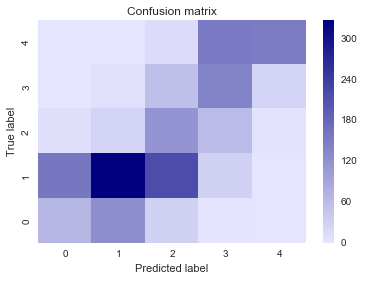

In [101]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
print(confusion_matrix(affinity_label(y_test),affinity_label(lr_pred)))
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(confusion_matrix(affinity_label(y_test),affinity_label(lr_pred)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

[[1087  102]
 [  78  474]]


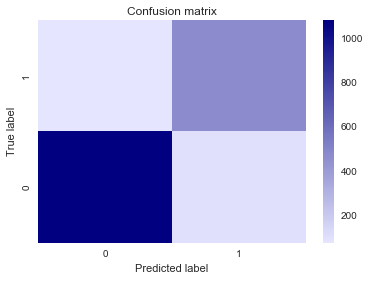

In [102]:
print(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(lr_pred,500)))
sns.heatmap(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(lr_pred,500)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

## SVM

[[ 68 125  32   3   0]
 [160 328 220  31   2]
 [ 10  27 117  61   5]
 [  0   8  56 142  28]
 [  0   0  14 153 151]]


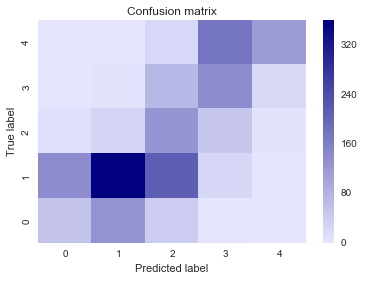

In [103]:
svm = SVR()
svm.fit(X_train,y_train[:,0])
svm_pred = svm.predict(X_test)
print(confusion_matrix(affinity_label(y_test),affinity_label(lr_pred)))
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(confusion_matrix(affinity_label(y_test),affinity_label(svm_pred)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

[[1105   84]
 [  99  453]]


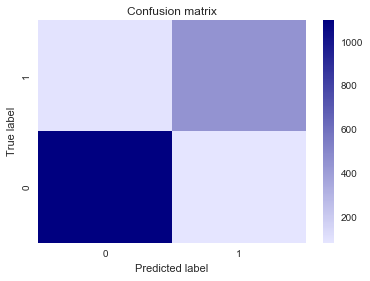

In [104]:
print(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(svm_pred,500)))
sns.heatmap(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(svm_pred,500)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

## GradientBoostingRegressor

[[ 58 136  32   2   0]
 [141 373 200  25   2]
 [ 10  33 115  57   5]
 [  0   5  69 126  34]
 [  0   0  19 159 140]]


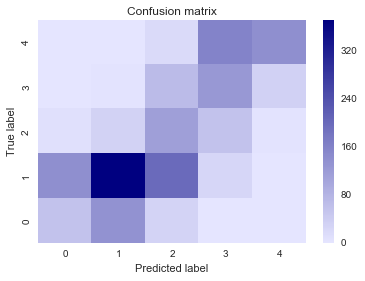

In [106]:
gbr = GradientBoostingRegressor(n_estimators = 328, max_depth = 2, learning_rate = 0.28)
gbr.fit(X_train,y_train[:,0])
gbr_pred = gbr.predict(X_test)
print(confusion_matrix(affinity_label(y_test),affinity_label(gbr_pred)))
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(confusion_matrix(affinity_label(y_test),affinity_label(gbr_pred)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

[[1098   91]
 [  93  459]]


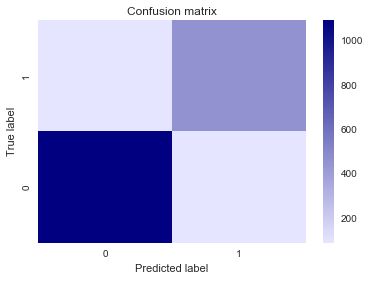

In [107]:
print(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(gbr_pred,500)))
sns.heatmap(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(gbr_pred,500)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()